In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve historical market data
data = yf.download('AAPL', start='2015-01-01', end='2022-02-22')

# Define trading strategy
def sma_crossover(data, short_window=50, long_window=200):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()

    return signals

# Backtest trading strategy
signals = sma_crossover(data)



[*********************100%***********************]  1 of 1 completed


/var/folders/p0/g25q1m1s04g_qcnn09rhm0_c0000gn/T/ipykernel_2405/2515736855.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)


In [16]:
initial_capital = float(100000.0)

positions = pd.DataFrame(index=signals.index).fillna(0.0)

positions['AAPL'] = 100 * signals['signal']
print(positions['AAPL'])
portfolio = positions.multiply(data['Adj Close'], axis=0)

pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(data['Adj Close'], axis=0)).sum(axis=1)



portfolio['cash'] = initial_capital - (pos_diff.multiply(data['Adj Close'], axis=0)).sum(axis=1).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()


Date
2015-01-02      0
2015-01-05      0
2015-01-06      0
2015-01-07      0
2015-01-08      0
             ... 
2022-02-14    100
2022-02-15    100
2022-02-16    100
2022-02-17    100
2022-02-18    100
Name: AAPL, Length: 1797, dtype: int64


In [7]:
portfolio

AAPL      holdings           cash          total   returns
Date                                                                          
2015-01-02      0.000000      0.000000  100000.000000  100000.000000       NaN
2015-01-05      0.000000      0.000000  100000.000000  100000.000000  0.000000
2015-01-06      0.000000      0.000000  100000.000000  100000.000000  0.000000
2015-01-07      0.000000      0.000000  100000.000000  100000.000000  0.000000
2015-01-08      0.000000      0.000000  100000.000000  100000.000000  0.000000
...                  ...           ...            ...            ...       ...
2022-02-14  16763.127136  16763.127136   96171.748924  112934.876060  0.000211
2022-02-15  17151.234436  17151.234436   96171.748924  113322.983360  0.003437
2022-02-16  17127.413940  17127.413940   96171.748924  113299.162865 -0.000210
2022-02-17  16763.127136  16763.127136   96171.748924  112934.876060 -0.003215
2022-02-18  16606.294250  16606.294250   96171.748924  112778.043175 -0.001389

[1797 rows x 5 columns]

Total Return:  -0.0013887019777503173
Average Daily Return:  6.780541691550148e-05
Standard Deviation of Daily Return:  0.0013027855843407265
Maximum Drawdown:  0.02458720148845627


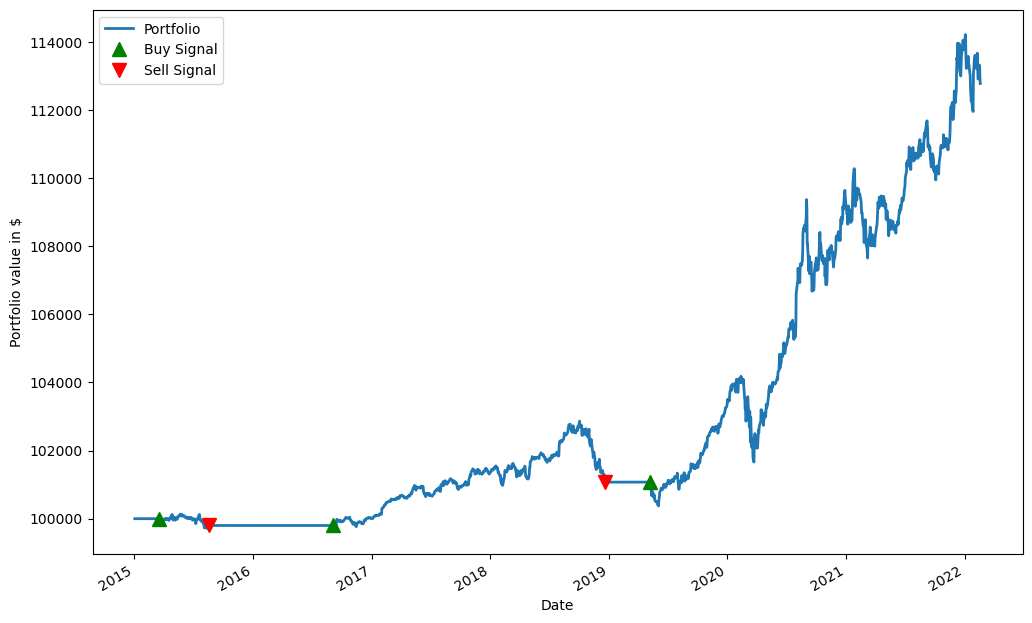

In [8]:
# Compute key performance metrics
print('Total Return: ', portfolio['returns'][-1])
print('Average Daily Return: ', portfolio['returns'].mean())
print('Standard Deviation of Daily Return: ', portfolio['returns'].std())
print('Maximum Drawdown: ', ((portfolio['total'].cummax() - portfolio['total']) / portfolio['total'].cummax()).max())

# Visualize backtesting results
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
portfolio['total'].plot(ax=ax1, lw=2.)
ax1.plot(portfolio.loc[signals.positions == 1.0].index, portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='g')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='r')
plt.legend(['Portfolio', 'Buy Signal', 'Sell Signal'])
plt.show()